In [501]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from __future__ import division

In [2]:
jointdf = pd.read_csv("C:/PhD/Rotations/Rotation_1/data/SV2/bedpe/combine/jointdf.bedpe",sep="\t",header=None)
jointdf.columns = ["Chrom1","start1","end1","Chrom2","start2","end2","type","score","samples","Description"]
print(jointdf.type.unique())
jointdf.head()
#order data
jointdf["Chrom1"] = pd.Categorical(jointdf["Chrom1"],categories = ["chr" + n for n in map(str,range(1,23))+["X","Y"]])
ethrank = ['Finnish','SOUTHERN HAN CHINESE','PUERTO RICAN','UTAH/MORMON','YORUBA/Nigeria','HAN CHINESE/China',
           'JAPANESE/Japan','USA/MEXICAN','USA/AFRICAN','ITALY/TOSCANI','Caucasian']
jointdf["Description"] = pd.Categorical(jointdf["Description"],categories = ethrank)
jointdf = jointdf.sort_values(by=["Description","Chrom1","start1"],ascending=True)

['inversion' 'deletion' 'reciprocal' 'inverted-reciprocal'
 'inverted-duplication' 'duplication' 'translocation'
 'inverted-translocation']


In [3]:
nsamples = jointdf.groupby(["Description"]).samples.nunique().reset_index()
nsamples.columns = ["Description","nsamples"]

#### TO DO

1. check number of SV and which feature contributed the most to the PCA plot

2. one more layer down: unique positions from samples of the SV - which population is more diverse (Utah)?

## Pairwise comparison

### Inversion and deletions

In [21]:
sub = jointdf[jointdf["type"].isin(["inversion","deletion"])]
sub.loc[:,"start"] = sub.loc[:,["start1","end1"]].min(axis=1).to_numpy()
sub.loc[:,"end"] = sub.loc[:,["start2","end2"]].min(axis=1).to_numpy()
sub.head()

,Chrom1,start1,end1,Chrom2,start2,end2,type,score,samples,Description,start,end
0,chr1,104171777,104170258,chr1,104266694,104266163,inversion,73,HG00276,Finnish,104170258,104266163
2,chr1,149266252,149266280,chr1,149651969,149650856,inversion,19,HG00276,Finnish,149266252,149650856
1,chr1,149334889,149334380,chr1,149722886,149721259,inversion,24,HG00276,Finnish,149334380,149721259
3,chr2,87573422,87571824,chr2,91762909,91761936,inversion,14,HG00276,Finnish,87571824,91761936
4,chr2,89122655,89132244,chr2,89521742,89530369,deletion,6,HG00276,Finnish,89122655,89521742


In [502]:
from __future__ import division
#1. percentage of inversion between two people
sub = jointdf[jointdf["type"].isin(["inversion"])]
sub.loc[:,"start"] = sub.loc[:,["start1","end1"]].min(axis=1).to_numpy()
sub.loc[:,"end"] = sub.loc[:,["start2","end2"]].min(axis=1).to_numpy()
sub.loc[:,"length"] = abs(sub.loc[:,"end"] - sub.loc[:,"start"])

#define length of overlap between two events
# a = [104170258, 104266163], b = [149266252, 149650856]
def len_overlap(a,b):
    if a[2] == b[2]:
        perc = len(range(max(a[0], b[0]), min(a[1], b[1]))) / (a[1]-a[0])
    else:
        perc = 0
    return(perc) #percentage of overlap with b for sequence a

#percentage of sequence overlap with person b for person a
def inversion_between_people(person_a,person_b): 
    a = sub[sub["samples"] == person_a]
    b = sub[sub["samples"] == person_b]
    a_list = list()
    for i in range(a.shape[0]):
        a_list.append([a.iloc[i,10],a.iloc[i,11],a.iloc[i,0]])
    b_list = list()
    for i in range(b.shape[0]):
        b_list.append([b.iloc[i,10],b.iloc[i,11],b.iloc[i,0]])
    #all length overlap = [sum([len_overlap(k,i) for i in b_list]) for k in a_list]
    a_overlap_sum = np.mean([np.max([len_overlap(k,i) for i in b_list]) for k in a_list]) #np.max - how good is best match for each sequence
    return(a_overlap_sum)
#     a_sum = int(sum(a.loc[:,"length"]))
#     a_perc = a_overlap_sum / a_sum
#     b_overlap_sum = np.mean([np.mean([len_overlap(k,i) for i in a_list]) for k in b_list])
#     b_sum = int(sum(b.loc[:,"length"]))
#     b_perc = b_overlap_sum / b_sum
#     return([a_overlap_sum,b_overlap_sum])

In [506]:
sample_list = jointdf.loc[:,"samples"].unique().tolist()
# row_list = list()
# for k in sample_list:
#     print(k)
#     row_list.append([inversion_between_people(k,j) for j in sample_list])
# sample_pair = pd.DataFrame(np.array(row_list))
sample_pair.columns = sample_list
sample_pair.index = sample_list
sample_pair.loc[:,"samples"] = sample_list
# sample_pair.to_csv("C:/PhD/Rotations/Rotation_1/data/SV2/bedpe/combine/sample_percent_overlap_inversion.csv",index=None)
# sample_pair.to_csv("C:/PhD/Rotations/Rotation_1/data/SV2/bedpe/combine/sample_percent_overlap_inversion_bestmatch.csv",index=None)

In [469]:
#normalize every row by diagonal element
# diag = pd.DataFrame(np.diag(sample_pair))
# sample_norm = sample_pair/diag.values[:,:]

In [504]:
#ethnicity information
ethdf = pd.read_excel("C:/PhD/Rotations/Rotation_1/70_samples.xlsx")
ethdf = ethdf.iloc[:,[0,1]]
ethdf.columns = ["samples","ethnicity"]
ethdf["samples"] = ethdf.loc[:,"samples"].str.split("_",n=1,expand=True).loc[:,1]
sample_df = pd.DataFrame(sample_list)
sample_df.columns = ["samples"]
sample_df = pd.merge(sample_df,ethdf,on="samples",how="outer")

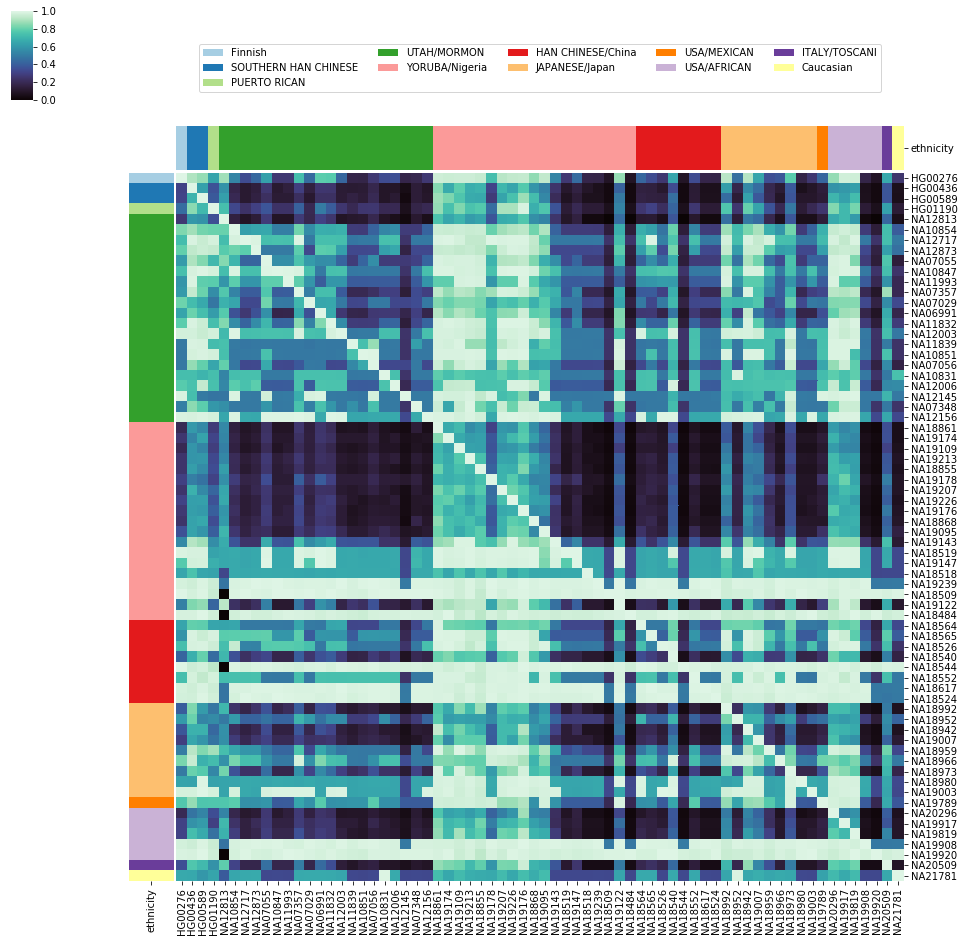

In [505]:
eth = sample_df.loc[:,"ethnicity"]
# network_pal = sns.husl_palette(11, s=.45)
network_pal = sns.color_palette("Paired")[:11]
network_lut = dict(zip(eth.unique(),network_pal))
network_colors = eth.map(network_lut)
network_colors.index = sample_df.loc[:,"samples"]
g = sns.clustermap(sample_norm,row_colors=network_colors,col_colors=network_colors, cmap="mako",
               row_cluster=False, col_cluster=False,
               linewidths=0, figsize=(16, 16))
# Draw the legend bar for the classes                 
for label in eth.unique():
    g.ax_col_dendrogram.bar(0, 0, color=network_lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
plt.show()
g.savefig("C:/PhD/Rotations/Rotation_1/writing_valor2/plots/inversion_overlap_perc_sample.pdf")

[0.77729307 0.06564305 0.02265269]


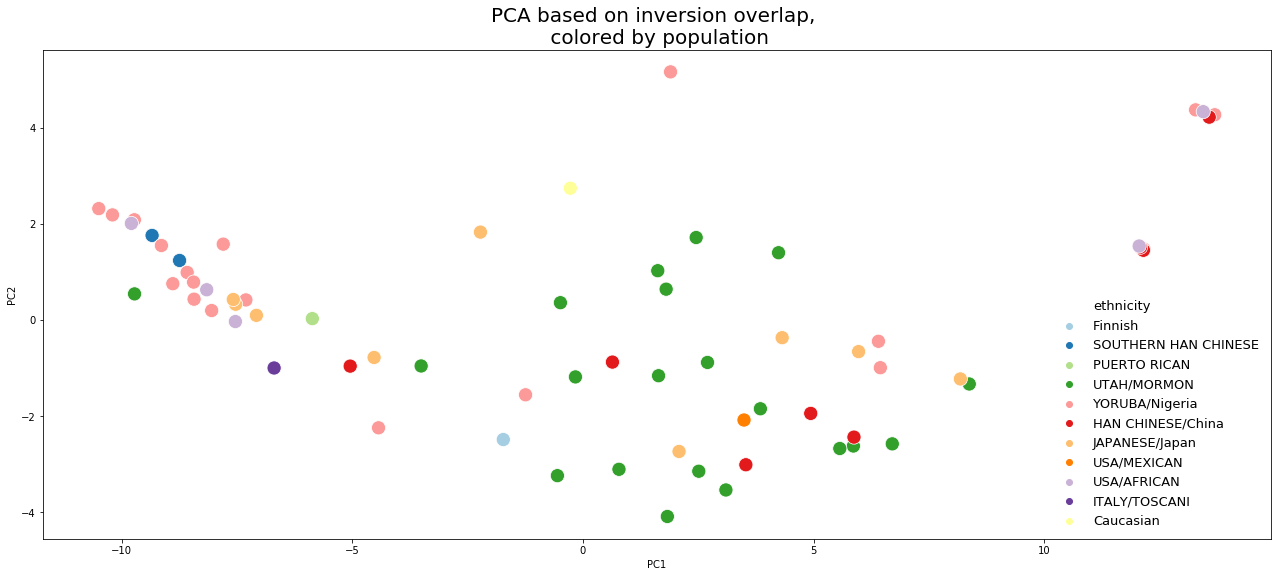

In [508]:
#PCA
sumdf2 = sample_pair.iloc[:,:-1]
X = sumdf2.iloc[:,:].values
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
pca = PCA(n_components = 3)
pc = pca.fit_transform(X)
pcdf = pd.concat([pd.Series(sample_list), pd.DataFrame(pc)], axis=1)
pcdf.columns = ["samples","PC1","PC2","PC3"]

print(pca.explained_variance_ratio_)

#ethnicity information
ethdf = pd.read_excel("C:/PhD/Rotations/Rotation_1/70_samples.xlsx")
ethdf = ethdf.iloc[:,[0,1]]
ethdf.columns = ["samples","ethnicity"]
ethdf["samples"] = ethdf.loc[:,"samples"].str.split("_",n=1,expand=True).loc[:,1]
pcdf = pd.merge(pcdf,ethdf,on="samples",how="outer")
# pcdf2 = pd.merge(pcdf,sumdf2,on="samples",how="outer")

# #Visualization
# plt.figure(figsize=(16,10))
plt.figure(figsize=(22,9))
g = sns.scatterplot("PC1","PC2",hue="ethnicity",data=pcdf,palette="Paired",s=200)
g.axes.set_title("PCA based on inversion overlap, \n colored by population",size=20)
g.legend(frameon=False,fontsize=13)
plt.show()
g.figure.savefig("C:/PhD/Rotations/Rotation_1/writing_valor2/plots/inversion_overlap_PCA.pdf")

## Hotspot for each population

In [520]:
sub = jointdf[jointdf["type"].isin(["inversion","deletion"])]
sub.loc[:,"start"] = sub.loc[:,["start1","end1"]].min(axis=1).to_numpy()
sub.loc[:,"end"] = sub.loc[:,["start2","end2"]].min(axis=1).to_numpy()
# sub_inversion = sub[sub["type"]=="inversion"]
# sub_inversion.loc[:,"sequence"] = ["seq_" + str(i) for i in range(sub_inversion.shape[0])]
sub.loc[:,"mid_position"] = (sub.loc[:,["start","end"]].mean(axis=1) / 100000).round()
sub.head()

,Chrom1,start1,end1,Chrom2,start2,end2,type,score,samples,Description,start,end,mid_position
0,chr1,104171777,104170258,chr1,104266694,104266163,inversion,73,HG00276,Finnish,104170258,104266163,1042.0
2,chr1,149266252,149266280,chr1,149651969,149650856,inversion,19,HG00276,Finnish,149266252,149650856,1495.0
1,chr1,149334889,149334380,chr1,149722886,149721259,inversion,24,HG00276,Finnish,149334380,149721259,1495.0
3,chr2,87573422,87571824,chr2,91762909,91761936,inversion,14,HG00276,Finnish,87571824,91761936,897.0
4,chr2,89122655,89132244,chr2,89521742,89530369,deletion,6,HG00276,Finnish,89122655,89521742,893.0


In [530]:
a = sub[sub["mid_position"]==1626.0]
a.loc[:,"length"] = a.loc[:,"end"] - a.loc[:,"start"]
np.mean(a.length)

127652.73333333334

In [526]:
sub2 = sub.groupby(["Chrom1","type","mid_position"]).start1.nunique().reset_index()
sub2[sub2["start1"]>=30].sort_values(["type","Chrom1","mid_position"],ascending = True)

,Chrom1,type,mid_position,start1
35,chr3,deletion,1626.0,30
9,chr1,inversion,170.0,32
11,chr1,inversion,1042.0,67
12,chr1,inversion,1429.0,30
18,chr1,inversion,1495.0,52
63,chr7,inversion,764.0,41
64,chr7,inversion,1022.0,30
117,chr14,inversion,1061.0,61
176,chr22,inversion,202.0,31


## Popular inversions

In [491]:
from __future__ import division
sub = jointdf[jointdf["type"].isin(["inversion","deletion"])]
sub.loc[:,"start"] = sub.loc[:,["start1","end1"]].min(axis=1).to_numpy()
sub.loc[:,"end"] = sub.loc[:,["start2","end2"]].min(axis=1).to_numpy()
sub_inversion = sub[sub["type"]=="inversion"]
sub_inversion.loc[:,"sequence"] = ["seq_" + str(i) for i in range(sub_inversion.shape[0])]
sub_inversion.head()

,Chrom1,start1,end1,Chrom2,start2,end2,type,score,samples,Description,start,end,sequence
0,chr1,104171777,104170258,chr1,104266694,104266163,inversion,73,HG00276,Finnish,104170258,104266163,seq_0
2,chr1,149266252,149266280,chr1,149651969,149650856,inversion,19,HG00276,Finnish,149266252,149650856,seq_1
1,chr1,149334889,149334380,chr1,149722886,149721259,inversion,24,HG00276,Finnish,149334380,149721259,seq_2
3,chr2,87573422,87571824,chr2,91762909,91761936,inversion,14,HG00276,Finnish,87571824,91761936,seq_3
7,chr5,691654,691500,chr5,784056,783283,inversion,21,HG00276,Finnish,691500,783283,seq_4


In [495]:
def len_overlap(a,b):
    return(len(range(max(a[0], b[0]), min(a[-1], b[-1]))) / (a[1]-a[0]))
seq_list = ["seq_" + str(i) for i in range(sub_inversion.shape[0])]
seq_overlap = [[len_overlap([sub_inversion.iloc[m,10],sub_inversion.iloc[m,11]],
            [sub_inversion.iloc[k,10],sub_inversion.iloc[k,11]]) for k in range(sub_inversion.shape[0])] for m in range(sub_inversion.shape[0])]

In [496]:
sample_overlap_df = pd.DataFrame(np.array(seq_overlap))
# sample_pair.columns = sample_list
# sample_pair.index = sample_list
# sample_pair.loc[:,"samples"] = sample_list
sample_overlap_df.to_csv("C:/PhD/Rotations/Rotation_1/data/SV2/bedpe/combine/sample_overlap.csv",index=None)


In [531]:
# sample_overlap_df

## Number of SVs in each category

[0.44985165 0.18040116 0.14994141]


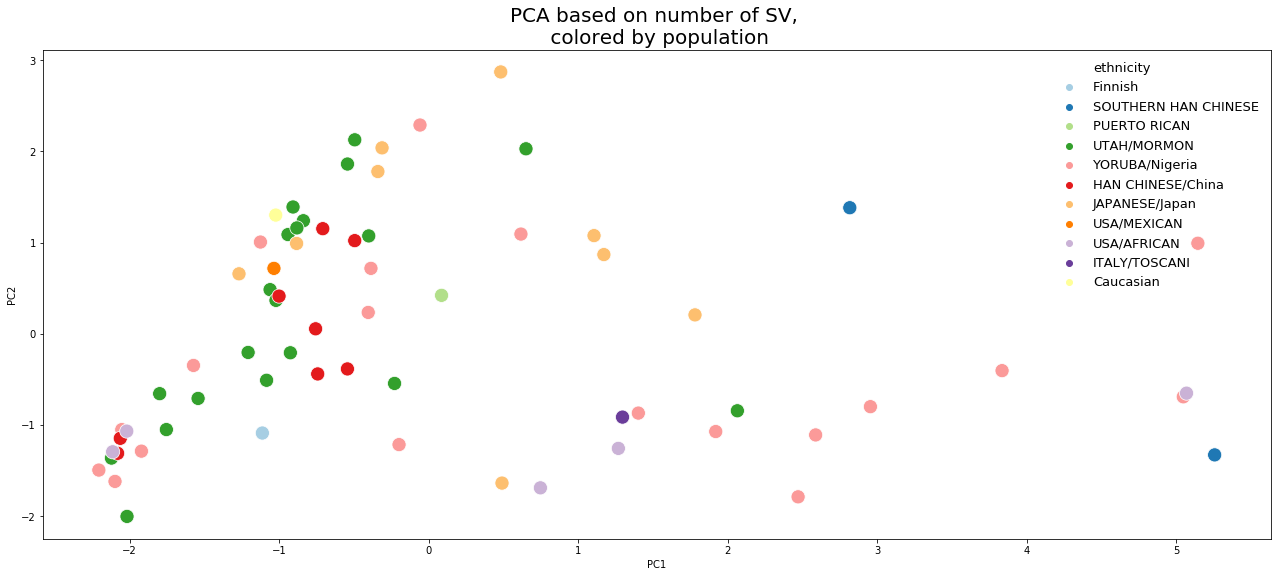

In [4]:
sumdf = jointdf.groupby(["Description","samples","type"]).start1.count().reset_index()
sumdf2 = sumdf.pivot("samples","type","start1").fillna(0)

#PCA
X = sumdf2.iloc[:,:].values
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
pca = PCA(n_components = 3)
pc = pca.fit_transform(X)
pcdf = pd.concat([pd.Series(list(sumdf2.index)), pd.DataFrame(pc)], axis=1)
pcdf.columns = ["samples","PC1","PC2","PC3"]

print(pca.explained_variance_ratio_)

#ethnicity information
ethdf = pd.read_excel("C:/PhD/Rotations/Rotation_1/70_samples.xlsx")
ethdf = ethdf.iloc[:,[0,1]]
ethdf.columns = ["samples","ethnicity"]
ethdf["samples"] = ethdf.loc[:,"samples"].str.split("_",n=1,expand=True).loc[:,1]
pcdf = pd.merge(pcdf,ethdf,on="samples",how="outer")
pcdf2 = pd.merge(pcdf,sumdf2,on="samples",how="outer")

#Visualization
# plt.figure(figsize=(16,10))
plt.figure(figsize=(22,9))
g = sns.scatterplot("PC1","PC2",hue="ethnicity",data=pcdf2,palette="Paired",s=200)
g.axes.set_title("PCA based on number of SV, \n colored by population",size=20)
g.legend(frameon=False,fontsize=13)
plt.show()

In [6]:
pcdf2.head()

,samples,PC1,PC2,PC3,ethnicity,deletion,duplication,inversion,inverted-duplication,inverted-reciprocal,inverted-translocation,reciprocal,translocation
0,HG00276,-1.112224,-1.089949,-0.154248,Finnish,4.0,0.0,11.0,0.0,5.0,0.0,2.0,0.0
1,HG00436,5.258027,-1.329813,1.789589,SOUTHERN HAN CHINESE,4.0,2.0,31.0,2.0,10.0,2.0,7.0,2.0
2,HG00589,2.817390,1.382436,-3.052680,SOUTHERN HAN CHINESE,9.0,0.0,29.0,2.0,20.0,0.0,10.0,0.0
3,HG01190,0.086377,0.420985,-0.936624,PUERTO RICAN,7.0,0.0,15.0,0.0,10.0,0.0,7.0,0.0
4,NA06991,-0.227977,-0.545758,0.157382,UTAH/MORMON,4.0,1.0,11.0,0.0,8.0,0.0,3.0,0.0


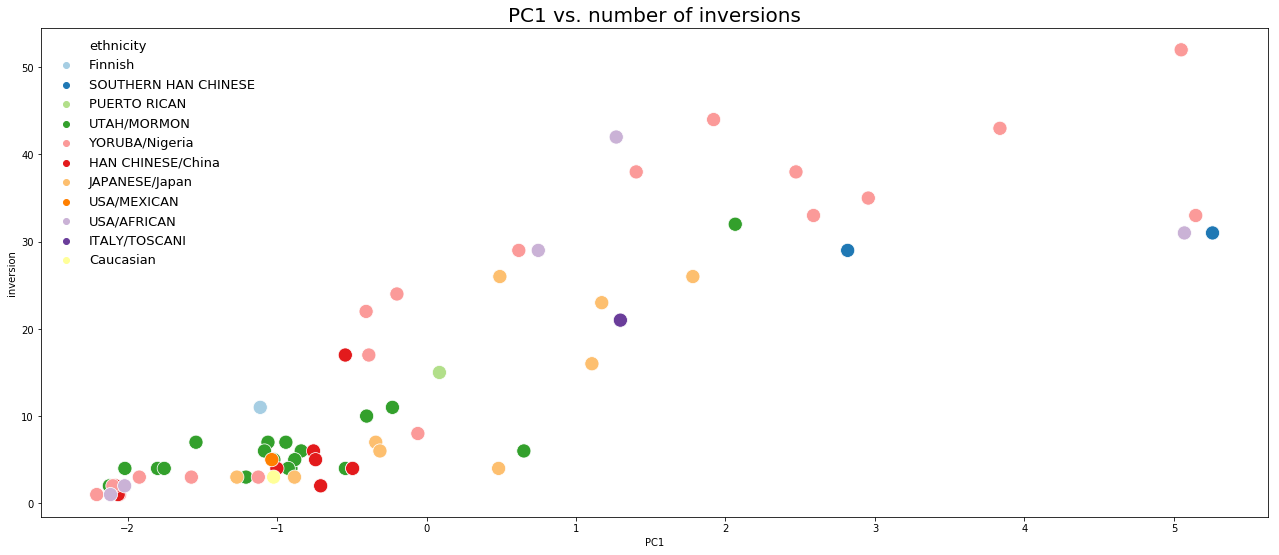

In [9]:
plt.figure(figsize=(22,9))
g = sns.scatterplot("PC1","inversion",hue="ethnicity",data=pcdf2,palette="Paired",s=200)
g.axes.set_title("PC1 vs. number of inversions",size=20)
g.legend(frameon=False,fontsize=13)
plt.show()

### Check loadings of components

In [55]:
loadings = pd.DataFrame(pca.components_)
loadings.columns = sumdf2.columns
loadings

type,deletion,duplication,inversion,inverted-duplication,inverted-reciprocal,inverted-translocation,reciprocal,translocation
0,0.353170,0.316856,0.453421,0.351394,0.235772,0.371911,0.284717,0.413322
1,-0.168329,-0.049777,-0.224524,-0.219879,0.681810,-0.077704,0.618591,-0.129891
2,-0.462281,0.186810,-0.258877,-0.379732,-0.033647,0.521422,-0.132191,0.499697


### Yoruba population

count    19.000000
mean     22.578947
std      17.289418
min       1.000000
25%       3.000000
50%      24.000000
75%      36.500000
max      52.000000
Name: inversion, dtype: float64


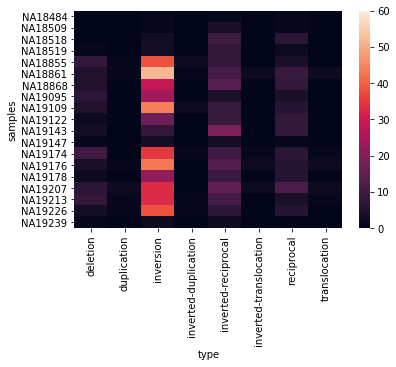

In [54]:
yoruba = sumdf[sumdf["Description"]=="YORUBA/Nigeria"]
yoruba2 = yoruba.pivot("samples","type","start1").fillna(0)

print(yoruba2.inversion.describe())

sns.heatmap(yoruba2,vmin=0, vmax=60)

### USA/African population

count     5.000000
mean     21.000000
std      18.479719
min       1.000000
25%       2.000000
50%      29.000000
75%      31.000000
max      42.000000
Name: inversion, dtype: float64


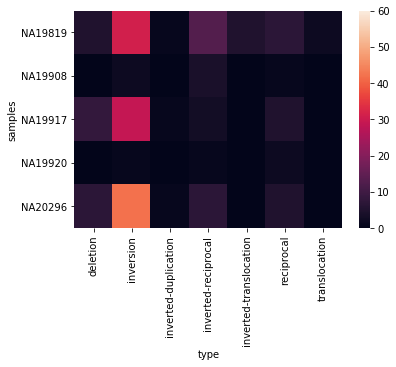

In [52]:
african = sumdf[sumdf["Description"]=="USA/AFRICAN"]
african2 = african.pivot("samples","type","start1").fillna(0)

print(african2.inversion.describe())

sns.heatmap(african2,vmin=0, vmax=60)

### Utah/Mormon population

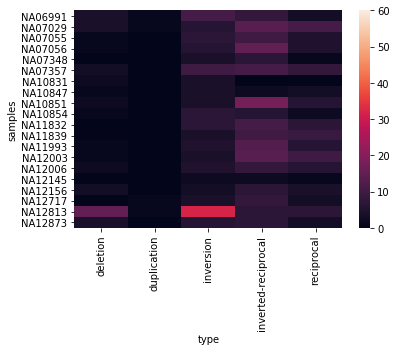

In [44]:
african = sumdf[sumdf["Description"]=="UTAH/MORMON"]
african2 = african.pivot("samples","type","start1").fillna(0)
sns.heatmap(african2,vmin=0, vmax=60)

## Unique positions from samples

Interestingly, from number of structural variants of each category, Yoruba and African population showed a large diversity: some samples have many SV while some are not. 

However, when checking location (Mb unit) of SV, Utah/Mormon population has a lot unique sites, which may indicate that although samples from Utah population has similar number of SVs, their locations are a little different. 

### Inversions and Deletions

In [52]:
sub = jointdf[jointdf["type"].isin(["inversion","deletion"])]
sub.loc[:,"start_location"] =  (sub[['start1', 'end1']].mean(axis=1)/1000000).round()
sub.loc[:,"end_location"] =  (sub[['start2', 'end2']].mean(axis=1)/1000000).round()

#based on start position, how diverse samples are within each population
sub1 = sub.groupby(["Description","type","Chrom1","start_location"]).samples.nunique().reset_index()
sub1 = pd.merge(nsamples,sub1,on="Description",how="outer")
sub1.loc[:,"percentage"] = sub1.loc[:,"samples"] / sub1.loc[:,"nsamples"]

In [82]:
# sub1[sub1["Description"]=="UTAH/MORMON"]

Finnish
SOUTHERN HAN CHINESE
PUERTO RICAN
UTAH/MORMON
YORUBA/Nigeria
HAN CHINESE/China
JAPANESE/Japan
USA/MEXICAN
USA/AFRICAN
ITALY/TOSCANI
Caucasian


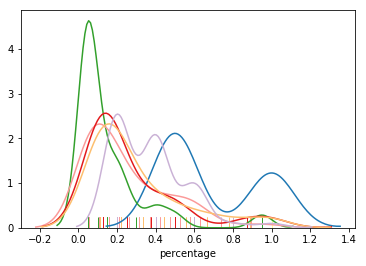

In [81]:
population = sub1.Description.unique().tolist()
# print(population)
for i in range(len(population)):
    a = population[i]
    subdist = sub1[sub1["Description"]==a]
    print(a)
    sns.distplot(subdist.loc[:,"percentage"],rug=True, hist=False,color=sns.color_palette("Paired")[i])

In [ ]:
sub = jointdf[~jointdf["type"].isin(["inversion","deletion"])]
sub.loc[:,"from_location"] =  (sub[['start1', 'end1']].mean(axis=1)/1000000).round()
sub.loc[:,"to_location"] =  (sub[['start2', 'end2']].mean(axis=1)/1000000).round()

## Utah/Mormon Population

In [7]:
sub = jointdf[jointdf["Description"] == "UTAH/MORMON"]

In [13]:
subinversion = sub[sub["type"]=="inversion"]
subchrom1 = sub[(sub["Chrom1"]=="chr1") & (sub["type"]=="inversion")]
sns.scatterplot(data=subchrom1,x="samples",y="start1")

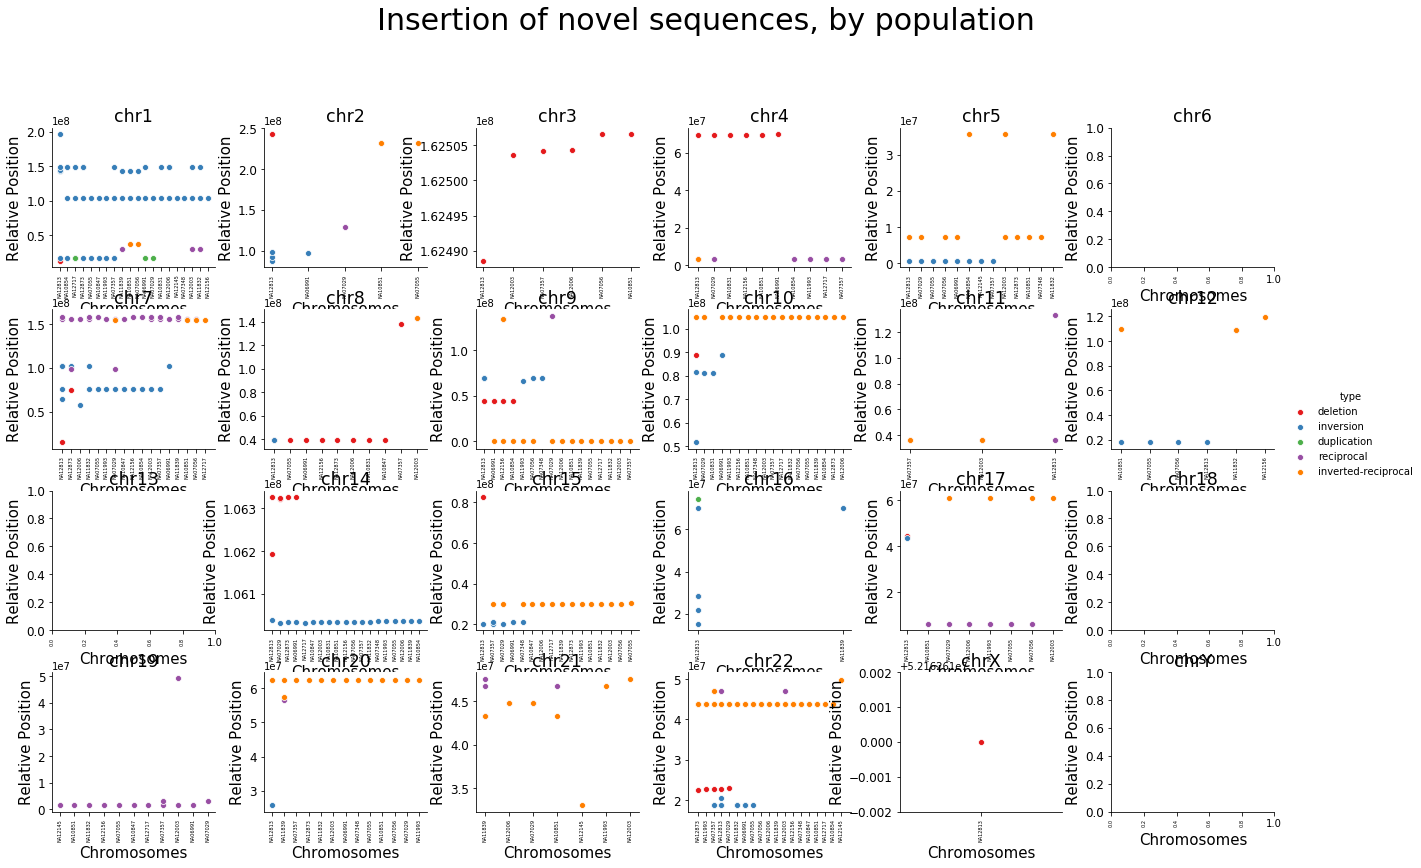

In [31]:
subchrom1 = jointdf[(jointdf["Description"]=="UTAH/MORMON")]
# sns.scatterplot(data=subchrom1,x="samples",y="start1")
g = sns.FacetGrid(subchrom1, col="Chrom1",col_wrap=6,margin_titles=True,
                  hue="type",palette = 'Set1',sharey=False,sharex=False)
g = (g.map(sns.scatterplot,"samples","start1").add_legend())
g.set_titles('{col_name}')
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_fontsize(5)
    for label in ax.get_yticklabels():
        label.set_fontsize(12)
    ax.set_xlabel("Samples",fontsize=15)
    ax.set_ylabel("Relative Position",fontsize=15)
    ax.set_title(ax.get_title(),fontsize="xx-large")
g.fig.suptitle("SV number and locations for samples in Utah/Mormon population",size=30)
g.fig.subplots_adjust(top=0.84)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

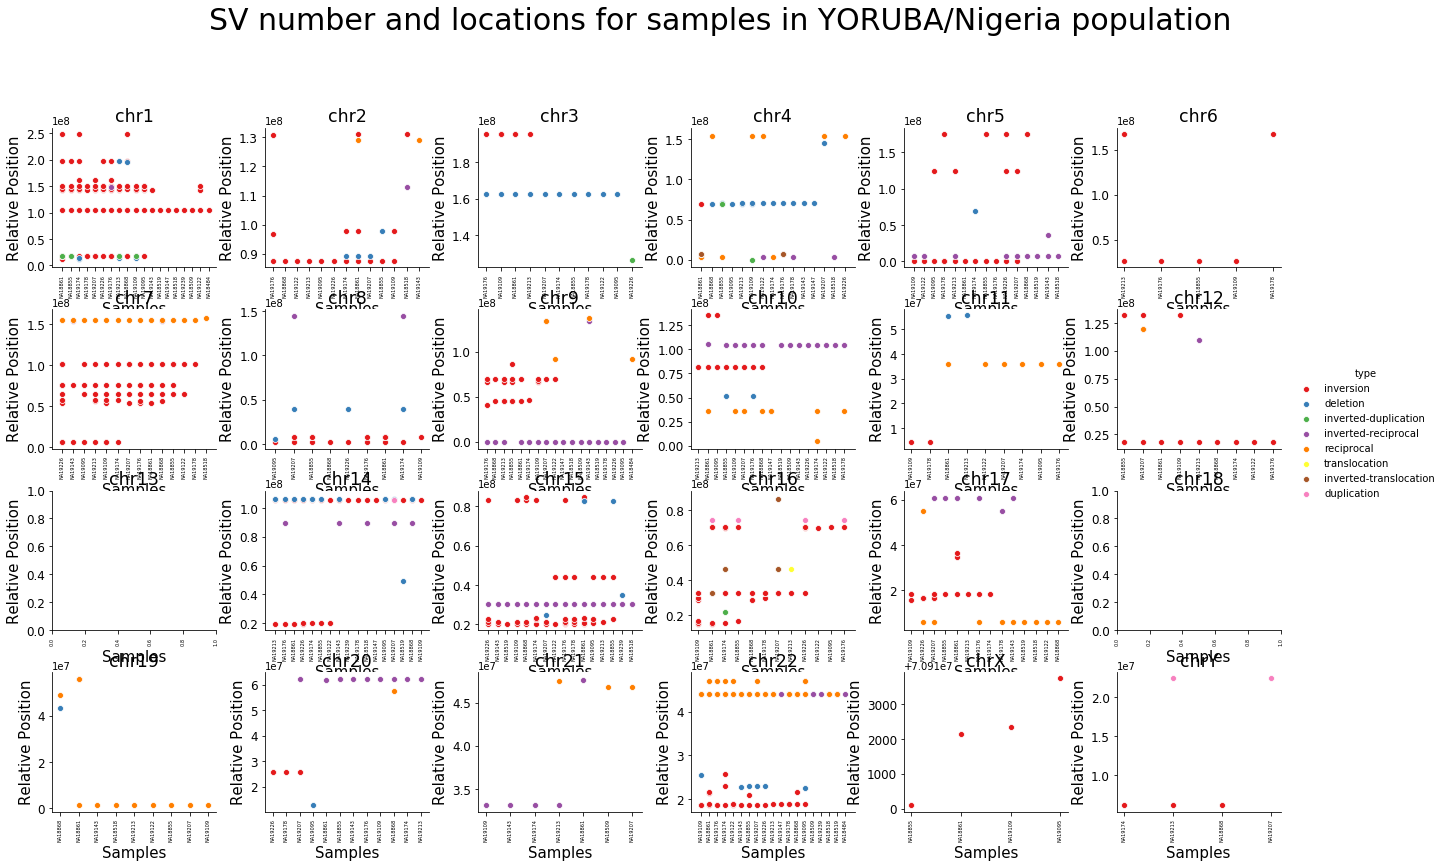

In [83]:
subchrom1 = jointdf[(jointdf["Description"]=="YORUBA/Nigeria")]#YORUBA/Nigeria
# sns.scatterplot(data=subchrom1,x="samples",y="start1")
g = sns.FacetGrid(subchrom1, col="Chrom1",col_wrap=6,margin_titles=True,
                  hue="type",palette = 'Set1',sharey=False,sharex=False)
g = (g.map(sns.scatterplot,"samples","start1").add_legend())
g.set_titles('{col_name}')
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_fontsize(5)
    for label in ax.get_yticklabels():
        label.set_fontsize(12)
    ax.set_xlabel("Samples",fontsize=15)
    ax.set_ylabel("Relative Position",fontsize=15)
    ax.set_title(ax.get_title(),fontsize="xx-large")
g.fig.suptitle("SV number and locations for samples in YORUBA/Nigeria population",size=30)
g.fig.subplots_adjust(top=0.84)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()